In [26]:
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models

IMG_SIZE_ORIG = 960
IMG_SIZE = 224
MASK_RADIUS = 25  # pixels

def get_image_path(tomo_id):
    #img_dir = '../data/pictures_process/adaptequal_05_padded'
    #img_dir = '../data/pictures_process/mean_image_padded'
    img_dir = '../data/pictures_process/adaptequal_1_padded'
    return os.path.join(img_dir, f'{tomo_id}.jpg')

def get_xy(tomo_id):
    csv_path = '../data/csv_raw/train_labels.csv'
    df = pd.read_csv(csv_path)
    y = df[df['tomo_id'] == tomo_id]['Motor_axis_1'].values[0]
    x = df[df['tomo_id'] == tomo_id]['Motor_axis_2'].values[0]
    return x, y

def get_tomo_ids():
    csv_path = '../data/csv_raw/train_labels.csv'
    df = pd.read_csv(csv_path)
    df_1_moteur = df[df['Number_of_motors'] == 1]
    return df_1_moteur['tomo_id'].unique()

X = []
Y_mask = []
for tomo_id in get_tomo_ids():
    xm, ym = get_xy(tomo_id)
    image_path = get_image_path(tomo_id)
    # Charger image grayscale, resize 224x224, stack en 3 canaux pour U-Net
    img = load_img(image_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0  # (224, 224, 1)
    img_array = np.repeat(img_array, 3, axis=2)  # (224, 224, 3)
    X.append(img_array)
    # Création du masque heatmap sans cv2
    mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    x_scaled = int(xm * IMG_SIZE / IMG_SIZE_ORIG)
    y_scaled = int(ym * IMG_SIZE / IMG_SIZE_ORIG)
    yy, xx = np.ogrid[:IMG_SIZE, :IMG_SIZE]
    dist_from_center = np.sqrt((xx - x_scaled)**2 + (yy - y_scaled)**2)
    mask[dist_from_center <= MASK_RADIUS] = 1.0
    Y_mask.append(mask[..., np.newaxis])  # Shape (224,224,1)

npX = np.array(X, dtype=np.float32)
npY_mask = np.array(Y_mask, dtype=np.float32)


In [27]:
from tensorflow.keras import Sequential, Input, layers

def simple_unet(input_shape):
    inputs = layers.Input(input_shape)
    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)
    # Bottleneck
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(b)
    # Decoder
    u2 = layers.UpSampling2D(2)(b)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(c3)
    u1 = layers.UpSampling2D(2)(c3)
    u1 = layers.concatenate([u1, c1])
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(c4)
    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(c4)
    return models.Model(inputs, outputs)

model = simple_unet((IMG_SIZE,IMG_SIZE,3))
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 240, 240, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 240, 240, 16  2320        ['conv2d_22[0][0]']              
                                )                                                           

In [28]:
history = model.fit(
    npX,
    npY_mask,
    epochs=5,
    batch_size=16,
    validation_split=0.2
)

Epoch 1/5
16/16 [==============================] - 45s 3s/step - loss: 0.2904 - val_loss: 0.1580
Epoch 2/5
16/16 [==============================] - 45s 3s/step - loss: 0.1497 - val_loss: 0.1406
Epoch 3/5
16/16 [==============================] - 46s 3s/step - loss: 0.1403 - val_loss: 0.1350
Epoch 4/5
16/16 [==============================] - 49s 3s/step - loss: 0.1361 - val_loss: 0.1316
Epoch 5/5
16/16 [==============================] - 52s 3s/step - loss: 0.1351 - val_loss: 0.1303


In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='MSE (train)')
plt.plot(history.history['val_mae'], label='MSE (val)')
plt.xlabel('Époque')
plt.ylabel('MSE')
plt.legend()
plt.title('Évolution de la MSE sur train et validation')
plt.show()

KeyError: 'mae'

1/1 [==============================] - 0s 78ms/step


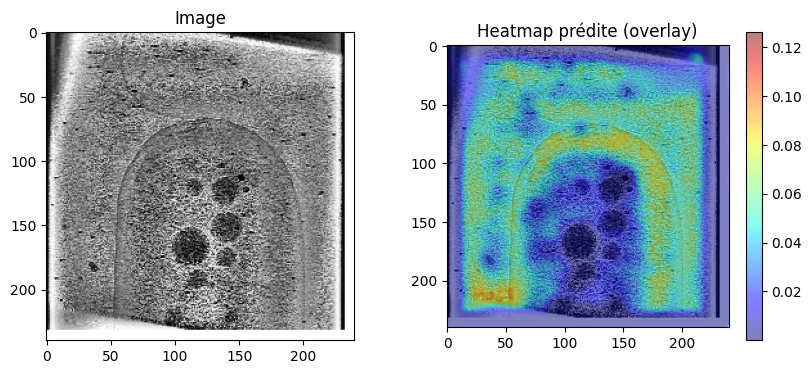

In [35]:
import matplotlib.pyplot as plt

# Exemple pour le premier échantillon (index 0)
i = 35
  # ou l'index de l'image que tu veux visualiser
img = npX[i]

# Prédire la heatmap (shape: 224x224)
pred_mask = model.predict(np.expand_dims(img, 0))[0, ..., 0]  # (224,224)

# Afficher l'image originale + la heatmap prédite en overlay
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(img[..., 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Heatmap prédite (overlay)")
plt.imshow(img[..., 0], cmap='gray')
plt.imshow(pred_mask, alpha=0.5, cmap='jet')
plt.colorbar()
plt.show()

In [17]:
import sys
sys.path.append('../src')
from utils.render_motor_position import draw_on_image


predictions = model.predict(npX)
predictions = predictions * 960

for i in range(len(get_tomo_ids())):
    tomo_id = get_tomo_ids()[i]
    x, y = get_xy(tomo_id)
    x_pred, y_pred = predictions[i]
    image_path = get_image_path(tomo_id)
    draw_on_image(
        image_path,
        '../data/pictures_process/motor_position_predict/',
        x, y, x_pred, y_pred
    )



10/10 [==============================] - 11s 1s/step


In [18]:
predictions

array([[553.1922 , 398.26984],
       [552.1532 , 396.53766],
       [552.3698 , 398.31836],
       [554.05865, 401.5322 ],
       [554.2269 , 399.74384],
       [555.59393, 389.52472],
       [553.8713 , 388.0604 ],
       [556.2314 , 395.44183],
       [555.3321 , 396.3906 ],
       [556.9162 , 394.90228],
       [553.20386, 384.74503],
       [554.1123 , 390.517  ],
       [554.7674 , 388.33374],
       [554.9932 , 393.99203],
       [552.8092 , 394.95682],
       [554.60614, 389.20767],
       [554.07074, 390.10187],
       [555.0049 , 390.0322 ],
       [553.468  , 386.71835],
       [555.00287, 393.3576 ],
       [556.4812 , 391.23392],
       [554.91077, 395.45325],
       [557.1931 , 398.85638],
       [555.4222 , 395.0313 ],
       [553.71796, 391.1943 ],
       [553.9033 , 392.4737 ],
       [552.53436, 394.99152],
       [554.9657 , 391.21057],
       [554.04834, 389.51593],
       [555.9333 , 393.9105 ],
       [556.0986 , 395.3994 ],
       [554.751  , 390.48056],
       [